# Regression diagnostics with statsmodels

_Author: Christoph Rahmede_

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Load-the-data" data-toc-modified-id="Load-the-data-1">Load the data</a></span></li><li><span><a href="#Fitting-with-statsmodels" data-toc-modified-id="Fitting-with-statsmodels-2">Fitting with statsmodels</a></span></li><li><span><a href="#Partial-regression-plot" data-toc-modified-id="Partial-regression-plot-3">Partial regression plot</a></span></li><li><span><a href="#CCPR-plot" data-toc-modified-id="CCPR-plot-4">CCPR plot</a></span></li><li><span><a href="#Outliers-and-high-leverage-points" data-toc-modified-id="Outliers-and-high-leverage-points-5">Outliers and high leverage points</a></span></li><li><span><a href="#Leverage-versus-normalized-residuals" data-toc-modified-id="Leverage-versus-normalized-residuals-6">Leverage versus normalized residuals</a></span></li><li><span><a href="#Influence-plot" data-toc-modified-id="Influence-plot-7">Influence plot</a></span></li><li><span><a href="#Cooks-distance" data-toc-modified-id="Cooks-distance-8">Cooks distance</a></span></li><li><span><a href="#Model-with-removed-influential-points" data-toc-modified-id="Model-with-removed-influential-points-9">Model with removed influential points</a></span></li><li><span><a href="#Variance-inflation-factor" data-toc-modified-id="Variance-inflation-factor-10">Variance inflation factor</a></span></li></ul></div>

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')
sns.set(font_scale=1.5)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.simplefilter('ignore')

## Load the data

In [2]:
df = pd.read_csv(
    '../../../dataset-collection/auto-mpg/auto-mpg.csv', sep='\s+', header=None)
df.columns = ['mpg', 'cylinders', 'displacement', 'horsepower',
              'weight', 'acceleration', 'year', 'origin', 'name']
df.drop(df[df.horsepower == '?'].index, inplace=True)
df['horsepower'] = df.horsepower.astype(float)
df['brand'] = df.name.map(lambda x: x.split(' ')[0]
                          ).replace(
    {'toyouta': 'toyota',
     'maxda': 'mazda',
     'chevroelt': 'chevrolet',
     'vw': 'volkswagen',
     'vokswagen': 'volkswagen',
     'mercedes-benz': 'mercedes'})
# this time we reset the index - this is important
df.reset_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 11 columns):
index           392 non-null int64
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null float64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
brand           392 non-null object
dtypes: float64(5), int64(4), object(2)
memory usage: 33.8+ KB


## Fitting with statsmodels

We can fit the same kind of model with statsmodels. We can work directly with the data matrices, but also the model setup with a formula is very appealing. The results will be exactly the same, but we receive some additional information.

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
formula = 'mpg~horsepower'  # +acceleration'
formula_all = 'mpg~' + \
    ('+').join([col for col in df.columns if col not in ['mpg',
                                                         'origin', 'name', 'brand']])
formula

'mpg~horsepower'

In [5]:
results = smf.OLS.from_formula(formula=formula, data=df).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Wed, 06 Feb 2019   Prob (F-statistic):           7.03e-81
Time:                        22:28:49   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [6]:
results = sm.OLS(df.mpg, sm.add_constant(df[['horsepower']]), sig=0.01).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Wed, 06 Feb 2019   Prob (F-statistic):           7.03e-81
Time:                        22:28:49   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

A nice way of illustrating the fit is by plotting the true values versus one of the predictors together with the predicted values. This can be done with a statsmodels-fitted model. The plot adds vertical lines which mark the predicted values plus or minus roughly two standard deviation. If the residuals are normally distributed, 95 % of the true values can be expected to be found within these bounds.

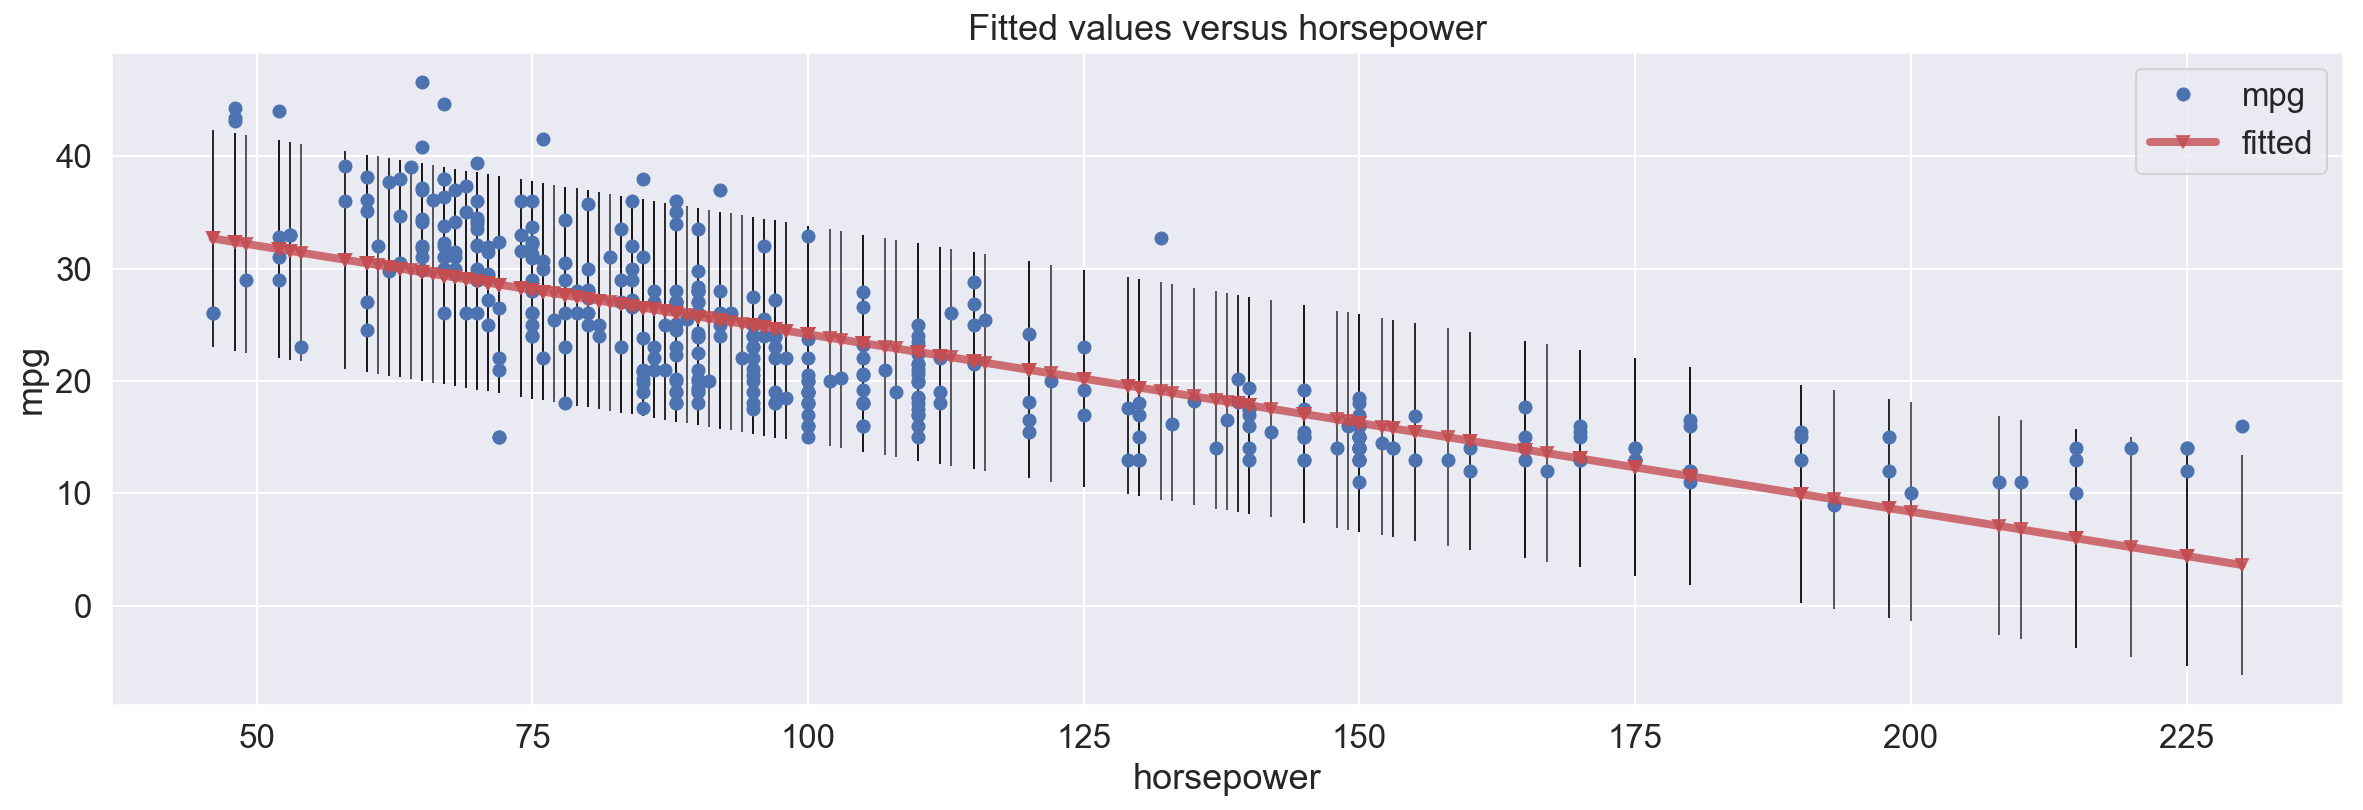

In [7]:
fig, ax = plt.subplots(figsize=(20, 6))
sm.graphics.plot_fit(results=results, exog_idx='horsepower', ax=ax, alpha=0.8, ls='-',
                     linewidth=4, marker='v')
plt.show()

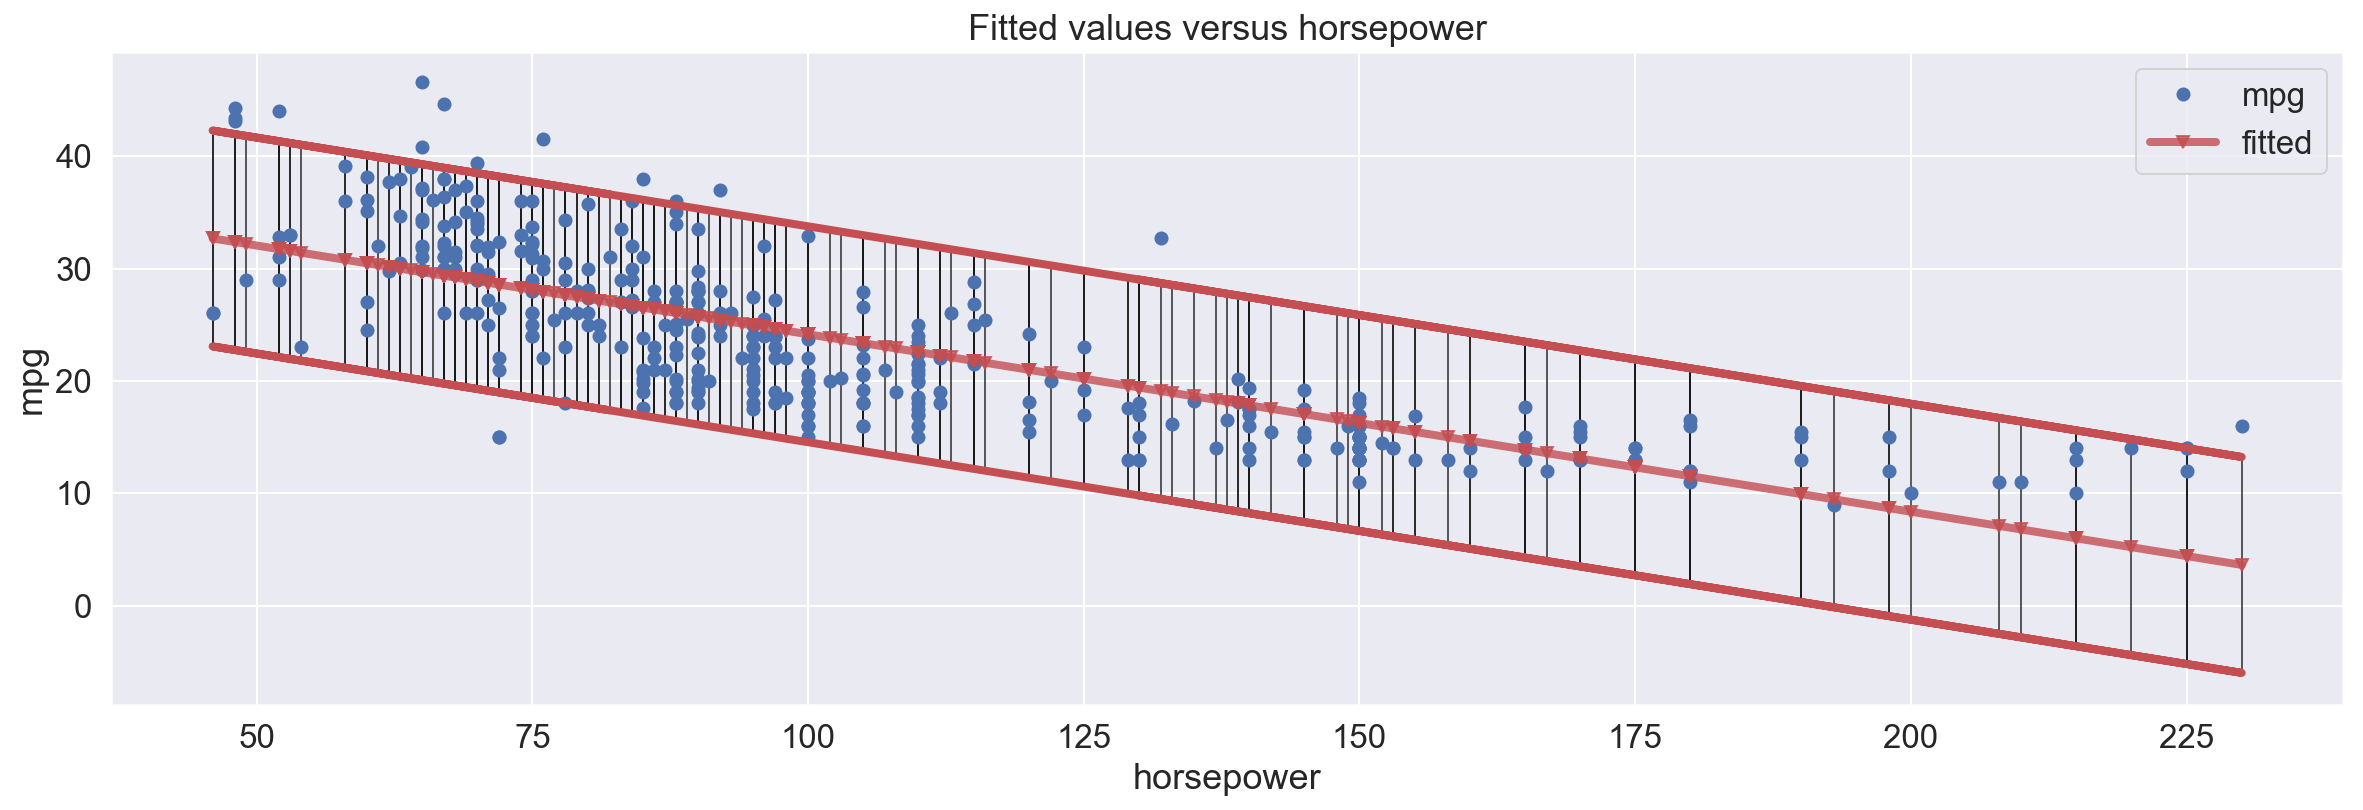

In [8]:
# Verify boundaries of bars
ax.plot(df.horsepower, results.predict(sm.add_constant(
    df[['horsepower']]))+1.96*results.resid.std(), lw=4, color='r')
ax.plot(df.horsepower, results.predict(sm.add_constant(
    df[['horsepower']]))-1.96*results.resid.std(), lw=4, color='r')
fig

We can easily extend to more than one predictor variable.

In [9]:
results = sm.OLS(df.mpg, sm.add_constant(
    df[['horsepower', 'acceleration']])).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.630
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                     331.7
Date:                Wed, 06 Feb 2019   Prob (F-statistic):           8.67e-85
Time:                        22:28:50   Log-Likelihood:                -1166.1
No. Observations:                 392   AIC:                             2338.
Df Residuals:                     389   BIC:                             2350.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           52.5593      2.587     20.316      0.000      47.473      57.646
horsepower      -0.1880      0.009    -21.788      0.000      -0.205      -0.171
acceleration    -0.6098      0.120     -5.066      0.000      -0.846      -0.373
==============================================================================
Omnibus:                       31.573   Durbin-Watson:                   0.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.488
Skew:                           0.685   Prob(JB):                     7.24e-09
Kurtosis:                       3.647   Cond. No.                     1.21e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.21e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Partial regression plot

Apart from the plots shown before, an interesting visualization is the partial regression plot. In this plot one chooses one of the predictors. Then the target variable is fit versus all the remaining predictors giving some residuals, different from the full fit. Then the chosen predictor variable is fitted versus all the other predictors giving another set of residuals. These two sets of residual are plotted versus  each other. The line stems from regressing the one set of residuals on the other one.

This plot can be interpreted as showing the effect of adding a new variable to the model. It illustrates

- the part of the target variable which is not explained by the parameters already in the model 
- the part of the new predictor variable not explained by the other predictors in the model
- the relation between target and predictor variable not due to the other variables

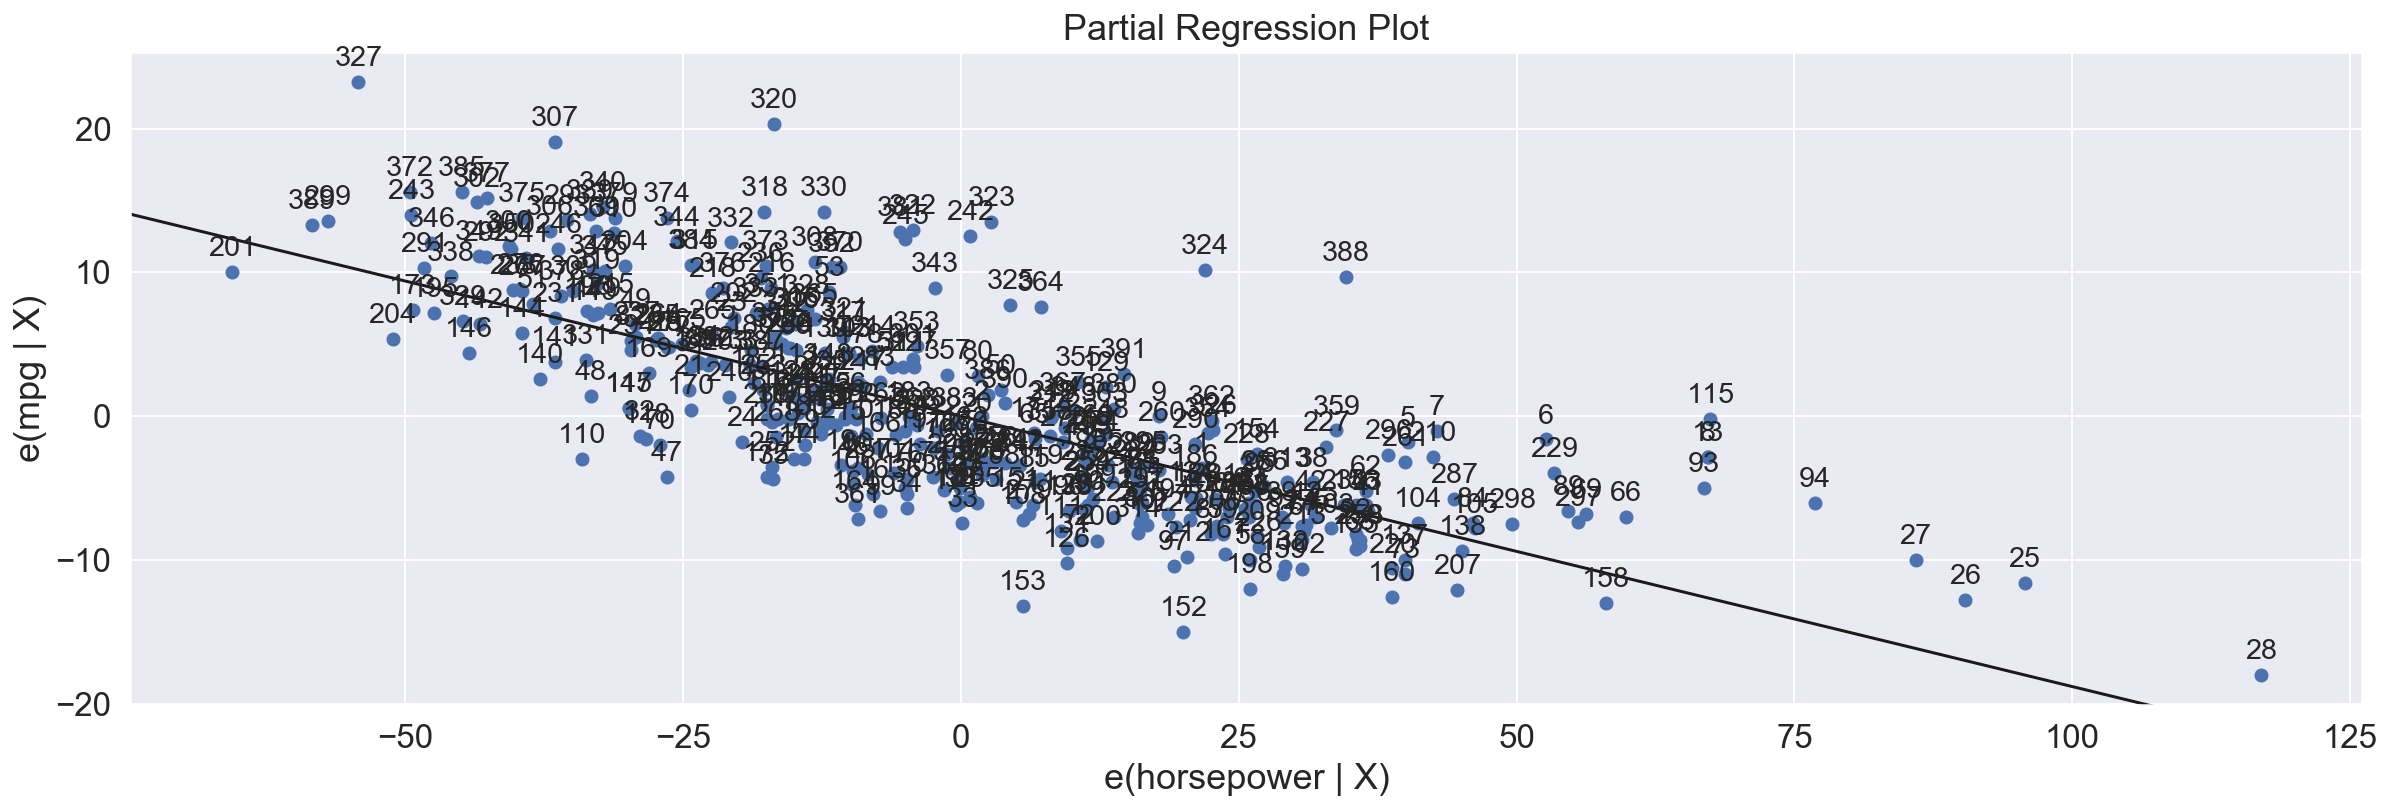

In [10]:
fig, ax = plt.subplots(figsize=(20, 6))
a = sm.graphics.plot_partregress(endog='mpg', exog_i='horsepower', exog_others=[
                                 'acceleration'], data=df, obs_labels=True, ret_coords=True, ax=ax)

Let's illustrate that procedure:

In [11]:
# fit the outcome on all the predictors
results_yhpacc = sm.OLS(df.mpg, sm.add_constant(
    df[['horsepower', 'acceleration']])).fit()
# fit the outcome on all but one predictor
results_yacc = sm.OLS(df.mpg, sm.add_constant(df[['acceleration']])).fit()
# fit the selected predictor on all the other predictors
results_hpacc = sm.OLS(
    df.horsepower, sm.add_constant(df[['acceleration']])).fit()
# fit the residuals of the model of all but one predictors on the residuals of the model
# for the selected predictor on all the other predictors
results_yhp = sm.OLS(results_yacc.resid,
                     sm.add_constant(results_hpacc.resid)).fit()

Note that the beta coefficient of the predictor chosen for the partial regression plot is the same as the slope in the final partial regression plot, i.e. the dependence in the model fit is correctly indicated.

In [12]:
results_yhpacc.params

const           52.559325
horsepower      -0.187966
acceleration    -0.609772
dtype: float64

In [13]:
results_yhp.params

const    1.915135e-15
0       -1.879664e-01
dtype: float64

The residuals of the full and partial model are the same:

In [14]:
np.allclose(results_yhpacc.resid, results_yhp.resid)

True

Let's add our regression line to the plot to check for agreement with statsmodels.

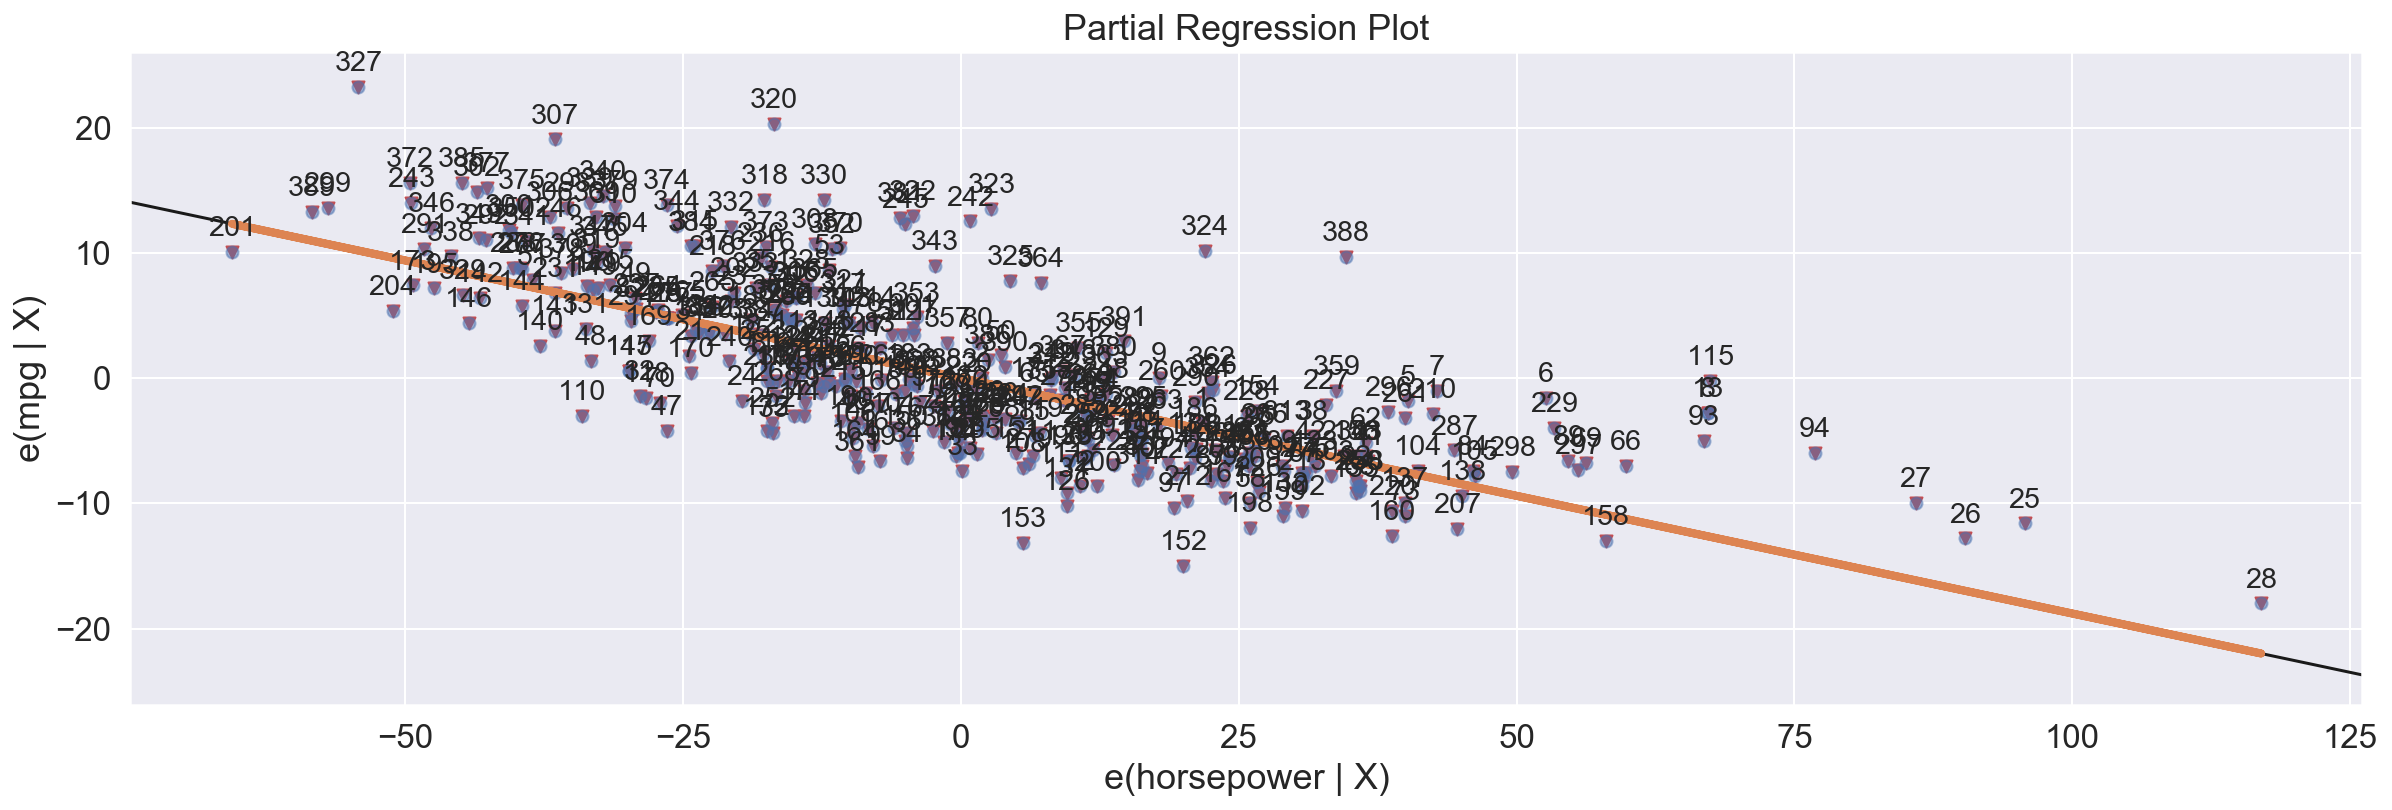

In [15]:
fig, ax = plt.subplots(figsize=(20, 6))
a = sm.graphics.plot_partregress(endog='mpg', exog_i='horsepower',
                                 exog_others=['acceleration'], data=df,
                                 obs_labels=True, ret_coords=True, ax=ax, linewidth=10, alpha=0.5)
ax.scatter(results_hpacc.resid, results_yacc.resid, marker='v', color='r')
ax.plot(results_hpacc.resid,
        results_yhp.params.const+results_yhp.params[0]*results_hpacc.resid,
        lw=4)
plt.show()

The same with more predictors included:

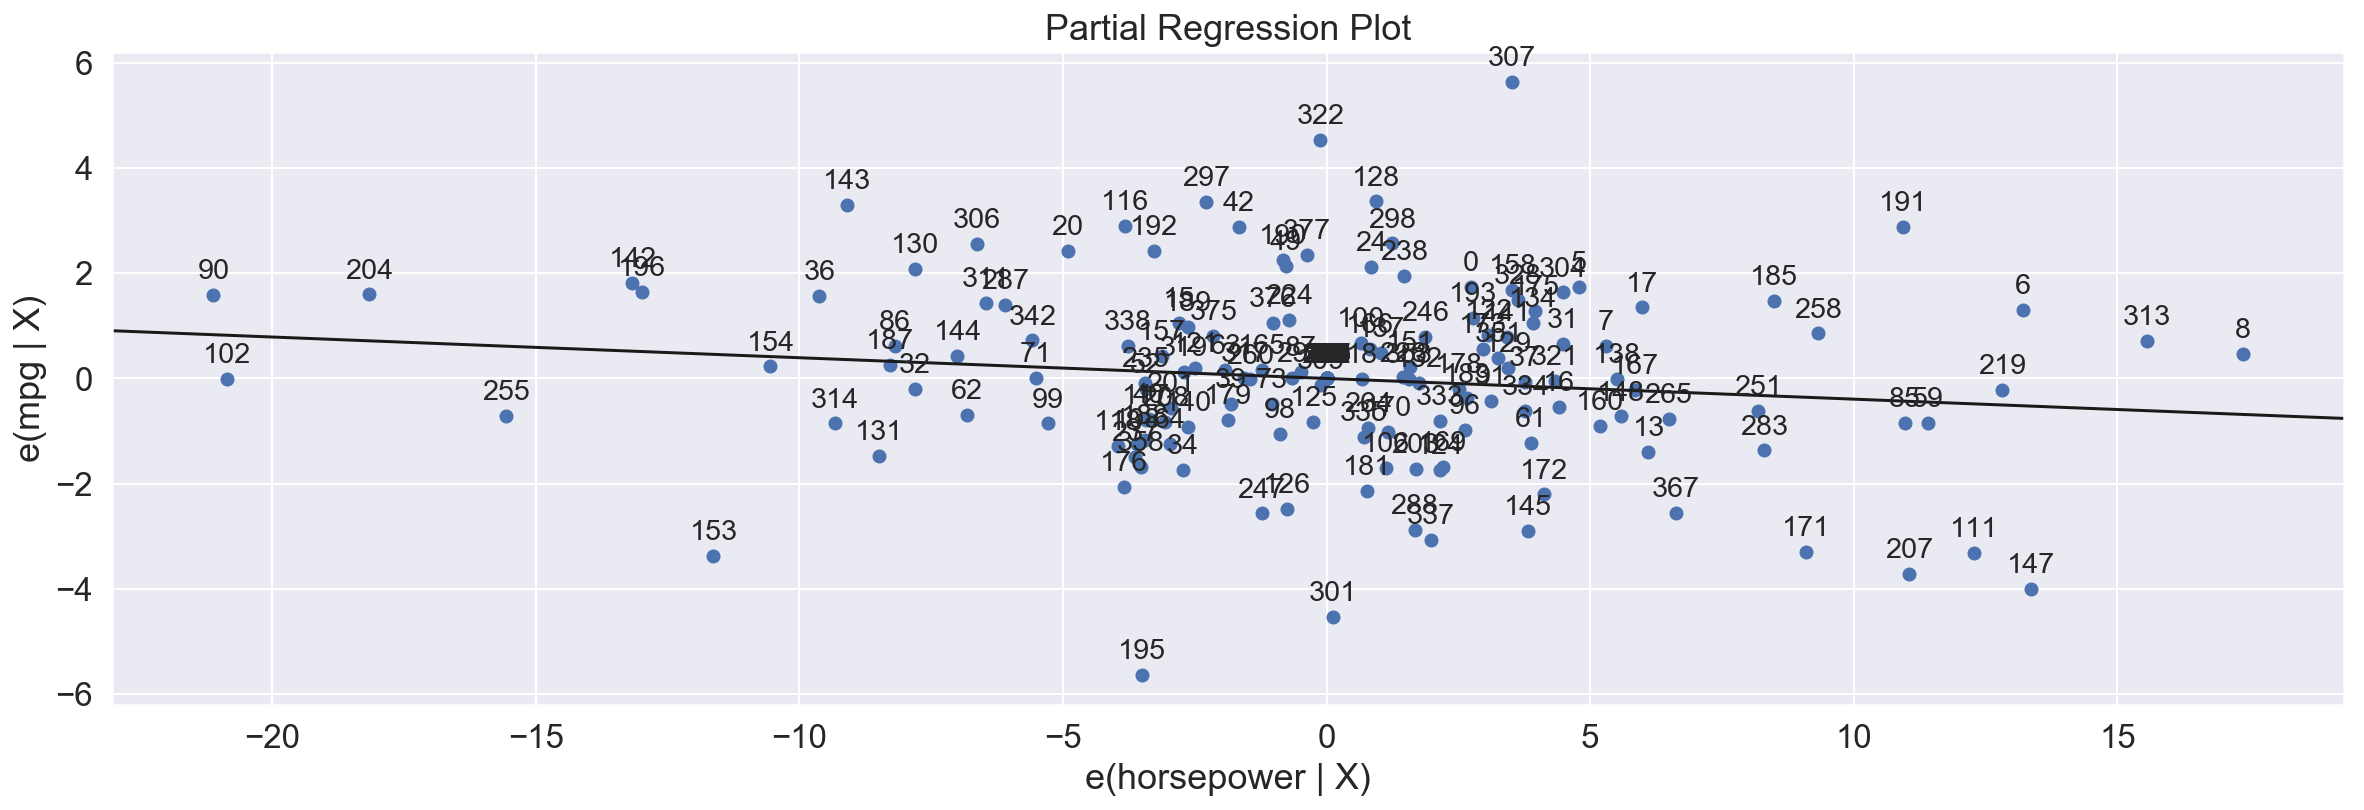

In [16]:
fig, ax = plt.subplots(figsize=(20, 6))
a = sm.graphics.plot_partregress(endog='mpg', exog_i='horsepower',
                                 exog_others=[col for col in df.columns if col not in [
                                     'mpg', 'horsepower']],
                                 data=df, obs_labels=True, ret_coords=True, ax=ax)
plt.show()

## CCPR plot

The component and component plus residual plot consists of two parts.
For the chosen variable $X_i$, the scatter plot shows

$$
\epsilon+X_i\beta_i
$$

versus $X_i$.

The "component" is the fitted line simply giving $X_i\beta_i$

The idea behind this plot is by adding back $X_i\beta_i$ into the residuals we retain only the contributions of the remaining variables to the residuals.

In [17]:
results.params

const           52.559325
horsepower      -0.187966
acceleration    -0.609772
dtype: float64

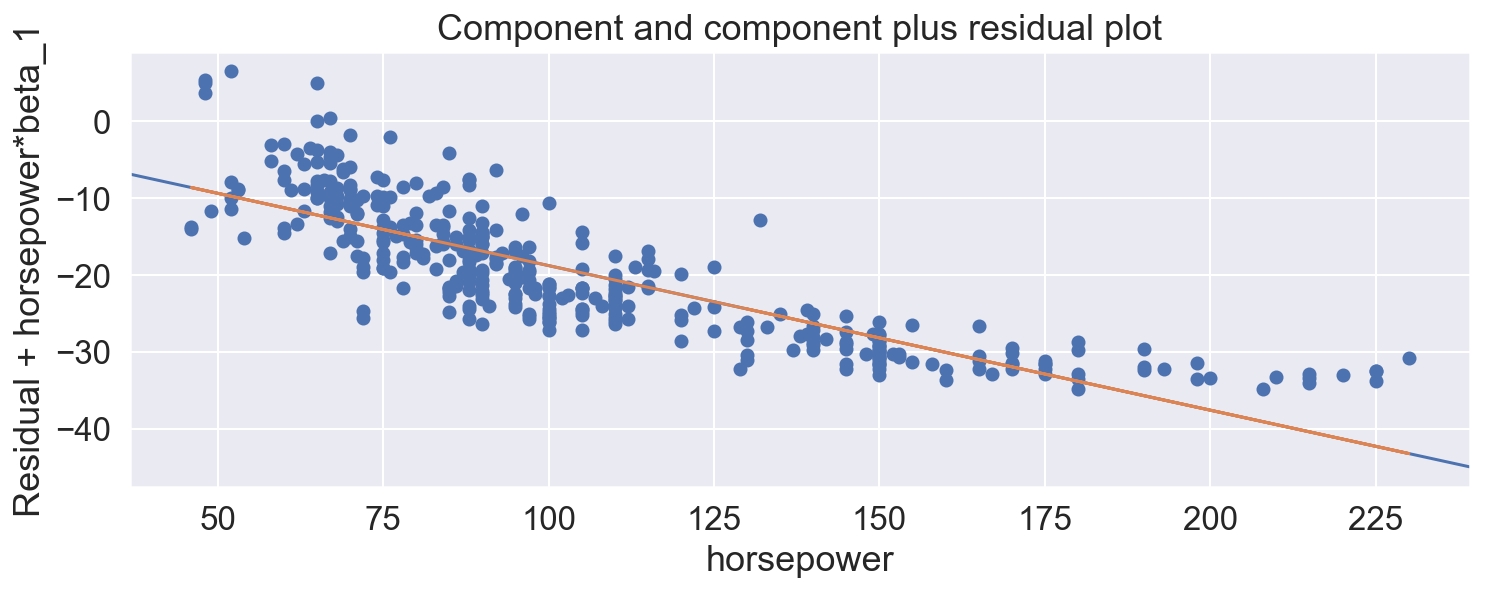

In [18]:
fig, ax = plt.subplots(figsize=(12, 4))
sm.graphics.plot_ccpr(results=results, exog_idx='horsepower', ax=ax)
ax.plot(df.horsepower, results.params.horsepower*df.horsepower)
plt.show()

Compare to the residuals plotted versus horsepower:

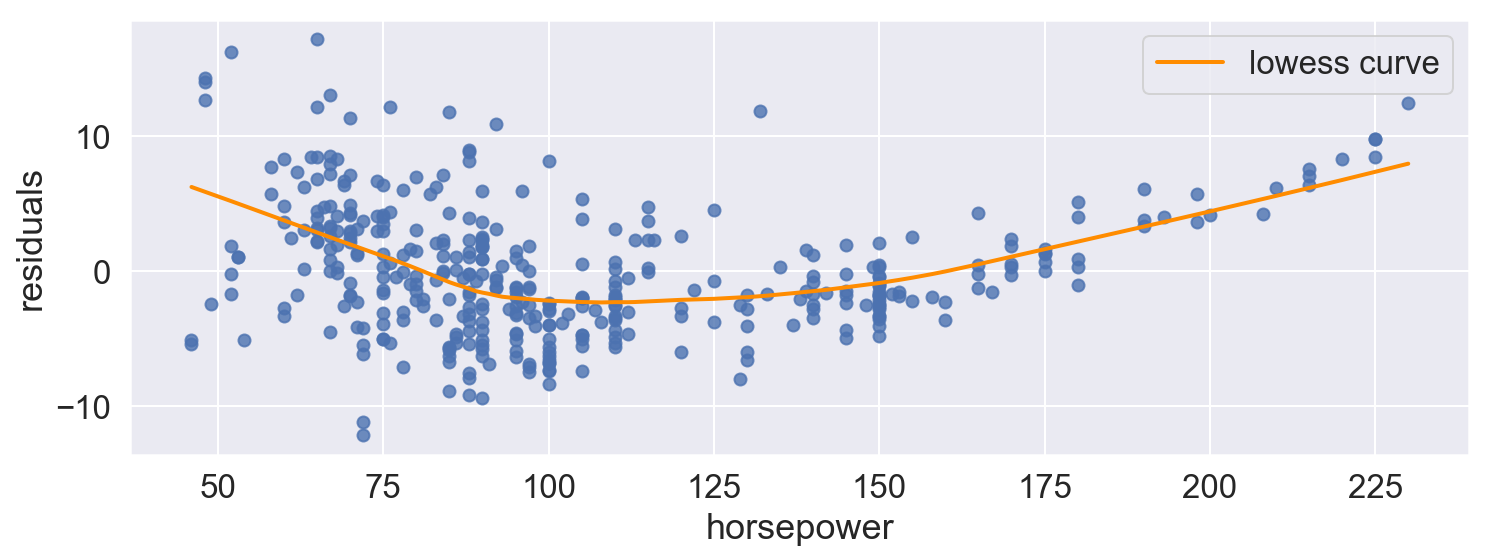

In [19]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.regplot(df.horsepower, results.resid, lowess=True, line_kws={
            'lw': 2, 'color': 'darkorange', 'label': 'lowess curve'})
ax.legend()
ax.set_xlabel('horsepower')
ax.set_ylabel('residuals')
plt.show()

## Outliers and high leverage points

In any kind of regression problem we might observe

- Outliers: observations with large residuals
- High leverage points: observations for which the predictor values are far from the mean

Having such points is not a bad sign per se. But it might indicate that some observations should be checked for correctness.

Identifying outliers is not an easy and completely well-defined task, but we can get a lot of useful measures from the results of the fitted statsmodels instance.

- Leverage

The model fit depends on the observed target values. We can determine how any predicted y-value would change if any of the observed target value were to change. The leverage measures the dependence of any predicted y-value on the related true target value.

$$
H_{ii}=\frac{\partial \hat{y}_i}{\partial y_i}
$$

- Normalized/standardized residuals

The residuals divided by their standard deviation

$$
\frac{\epsilon_i}{\sigma_\epsilon}
$$

Standardized residuals might serve for identifying outliers, but high-leverage points will typically have small standardized residuals because the model is forced to adjust to them. Therefore a better measure are studentized residuals.

- Studentized residuals


The standardized residuals divided by an additional factor becoming very small for high leverage

$$
\frac{\epsilon_i}{\sigma_\epsilon\sqrt{1-H_{ii}}}
$$

- Cook's distance

For each observation, Cook's distance is proportional to the mean quadratic distance between the predictions made with the whole training set and the predictions made on the whole training set excluding the current observation. For linear regression, this expression can be algebraically simplified.

$$
D_i = \frac{1}{p \sigma_\epsilon}\sum_{j=1}^n(\hat{y}_j-\hat{y}_{j(i)})^2 
= \frac{\epsilon_i^2}{\sigma_\epsilon^2}\frac{h_{ii}}{(1-h_{ii})^2}
$$

In [20]:
influence = results.get_influence()
leverage = results.get_influence().hat_matrix_diag
resid_studentized = influence.resid_studentized_internal
norm_residuals_2 = np.square(results.resid/results.resid.std())
cooks_distance = results.get_influence().cooks_distance[0]

In [21]:
# verify leverage
xx = sm.add_constant(df[['horsepower', 'acceleration']])
hhat = xx.dot(np.linalg.inv(xx.T.dot(xx)).dot(xx.T))
np.allclose(leverage, np.diag(hhat))

True

In [22]:
# verify studentized residuals
np.allclose(resid_studentized, ((results.resid) /
                                (results.resid.std(ddof=(1+results.df_model))*(1-leverage)**0.5)))

True

In [23]:
# Verify mse resid
np.isclose(results.mse_resid, np.sum(
    results.resid**2)/(len(df)-1-results.df_model))

True

In [24]:
# Verify Cook's distance
np.allclose(results.resid**2/((results.df_model+1)*results.mse_resid)
            * (leverage/(1-leverage)**2), cooks_distance)

True

## Leverage versus normalized residuals

The idea is the same as for the influence plot. However the residuals will not be inflated for high leverage.

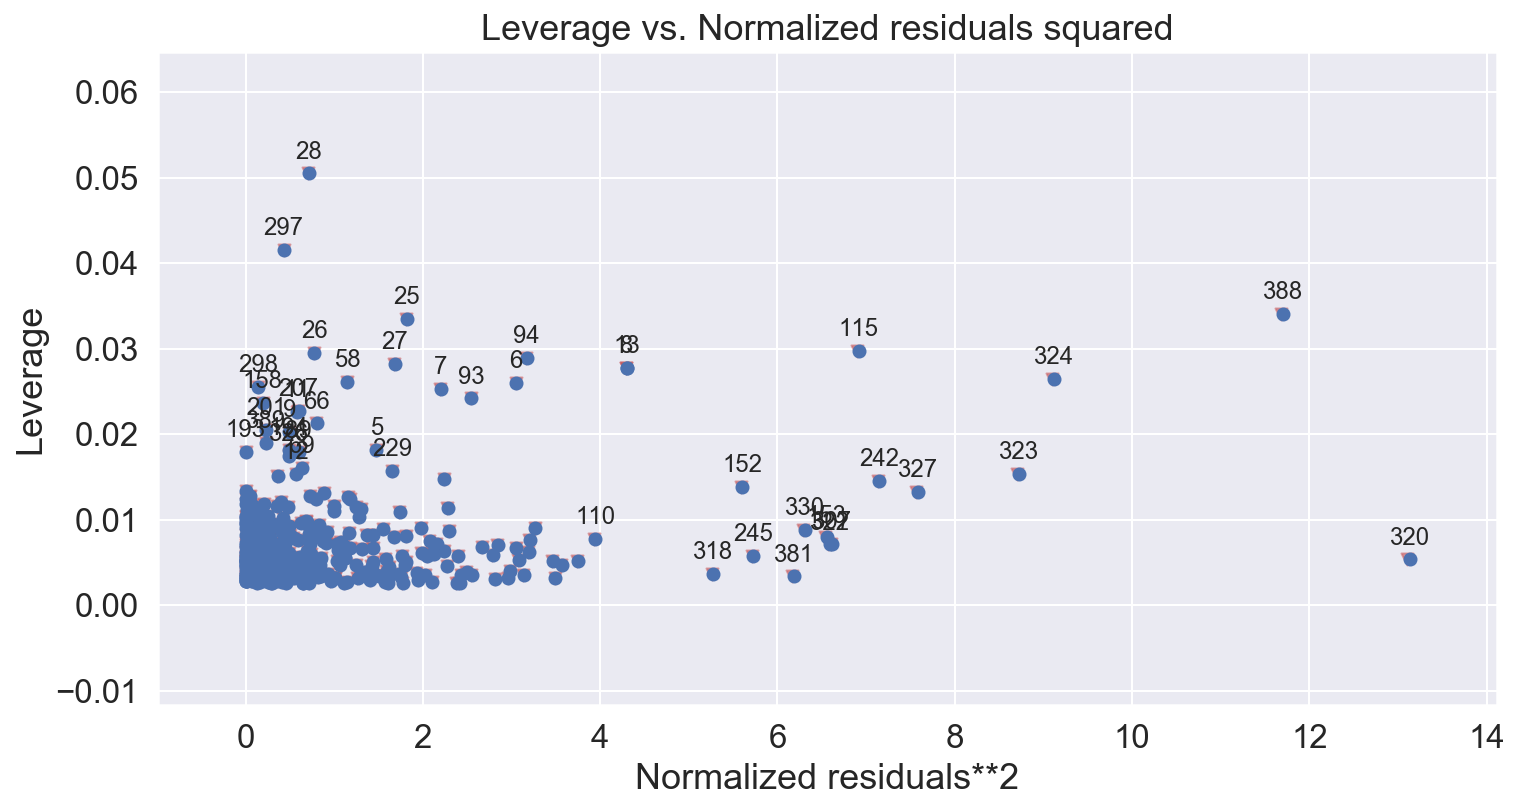

In [25]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(norm_residuals_2, leverage, color='r', alpha=0.5, marker='v')
sm.graphics.plot_leverage_resid2(results=results, ax=ax, alpha=0.05)
plt.show()

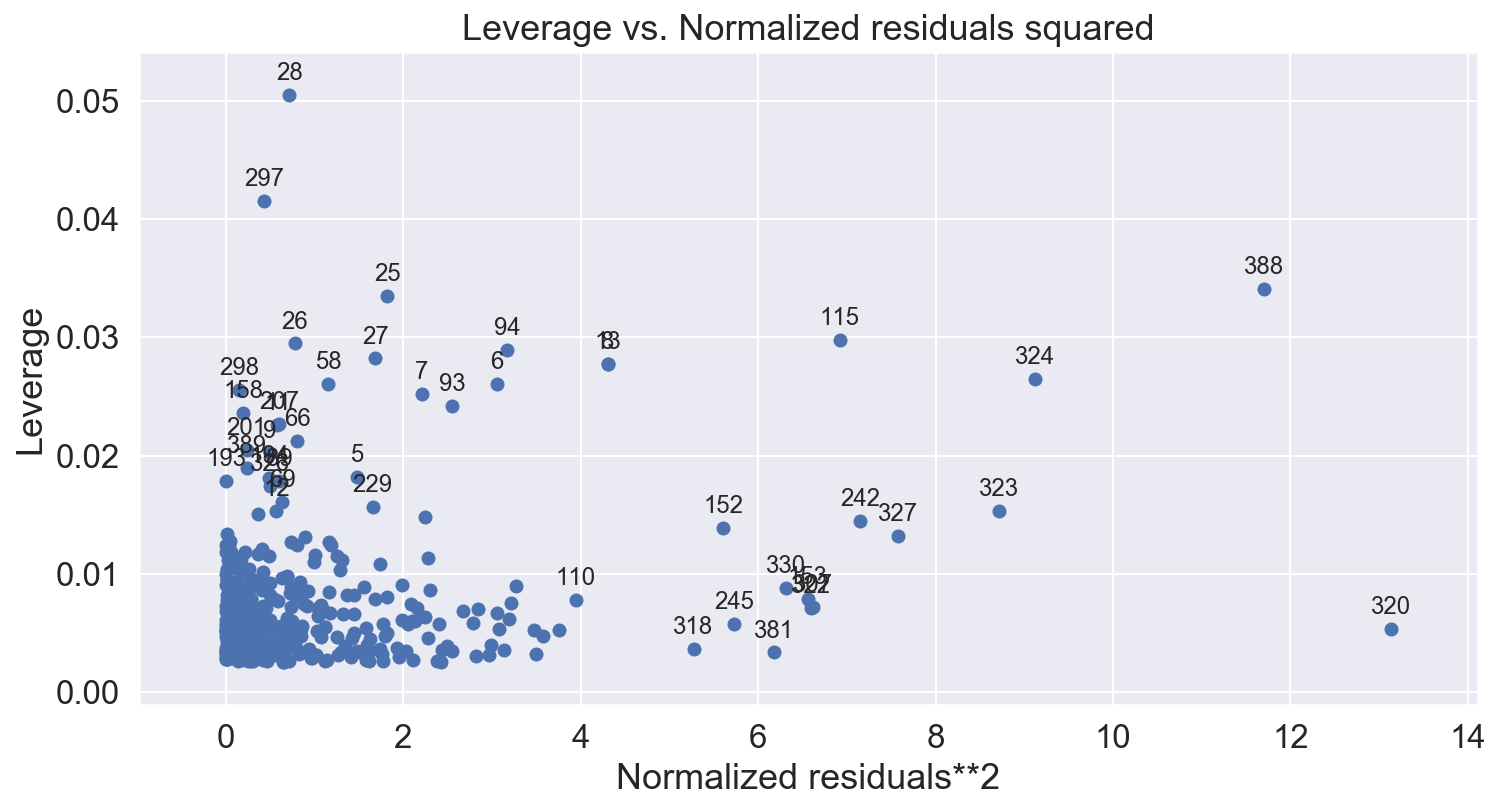

In [26]:
fig, ax = plt.subplots(figsize=(12, 6))
sm.graphics.plot_leverage_resid2(results=results, ax=ax)
plt.show()

## Influence plot

We can plot the studentized residuals versus the leverage for each observation. We don't need to be concerned about points with low residuals and low leverage of course, neither too much about points with low large residuals with low leverage or high leverage with low residuals since changes in their target values will not have a too strong effect on our model fit. We are concerned however about points having high values for both, in particular if they are detached from other points. Such points we would deem influential.

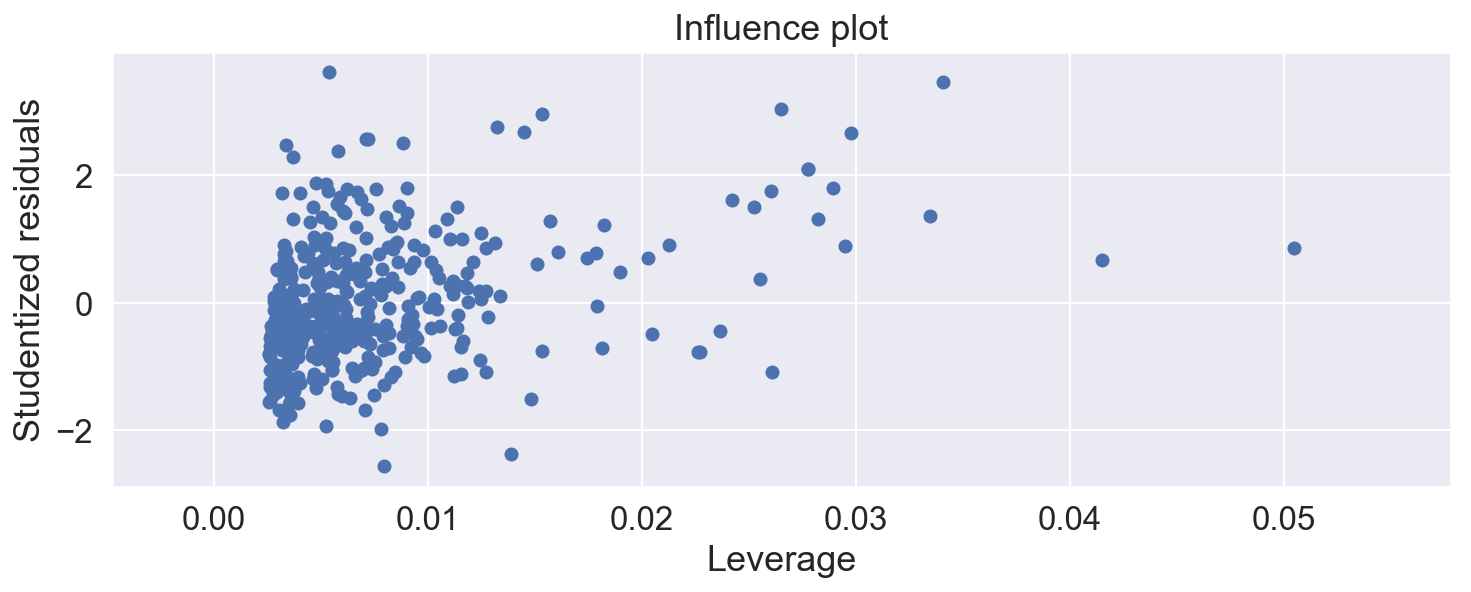

In [27]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(leverage, resid_studentized)
ax.set_xlabel('Leverage')
ax.set_ylabel('Studentized residuals')
ax.set_title('Influence plot')
plt.show()

Statsmodels produces this plot in the following way (overlay for verifying agreement). The size of the points is adjusted to the observed range of Cook's distance.

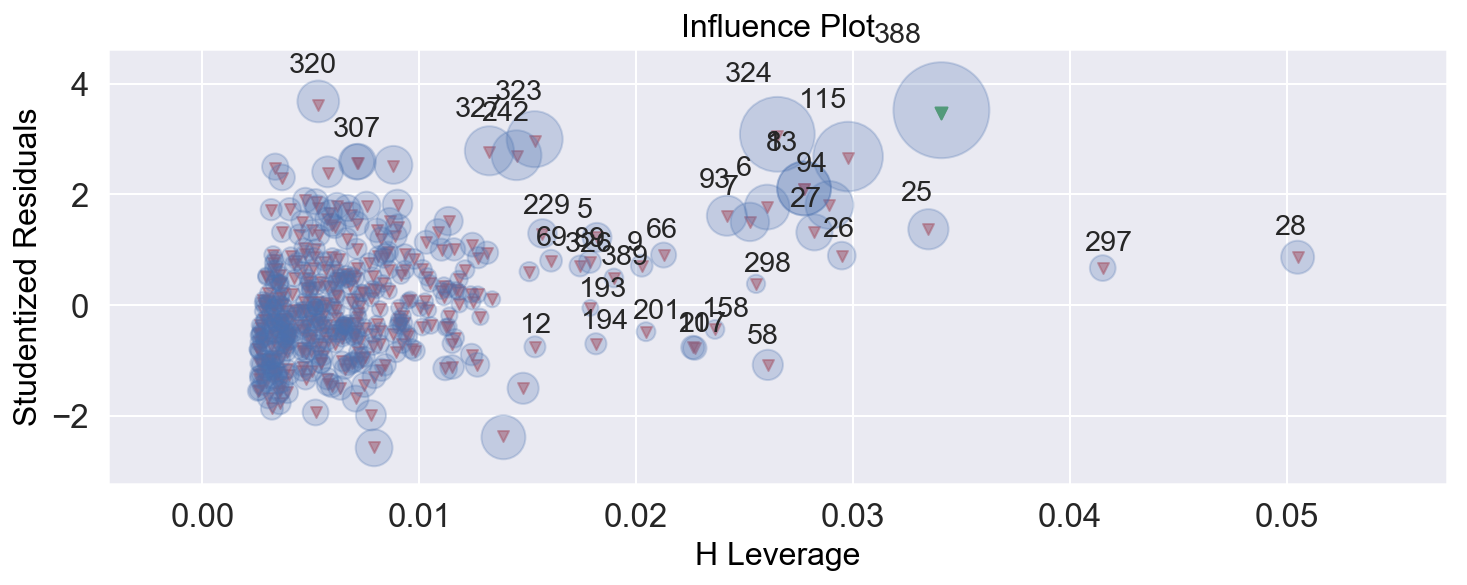

In [28]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.scatter(leverage, resid_studentized, color='r', s=30, marker='v', alpha=0.5)
ax.scatter([leverage[388]], [resid_studentized[388]], color='g', marker='v')
sm.graphics.influence_plot(results, alpha=0.01, external=True,  # size=0.01,
                           ax=ax, color='lightblue', criterion='cook', plot_alpha=0.25)
plt.show()

In [29]:
resid_studentized[388]

3.4678758770698432

In [30]:
leverage[388]

0.034068661172060255

## Cooks distance

Cook's distance measures for each observation the ratio of the mean squared errors obtained for the model fitted on the whole data and the model fitted on all observations except the current one, therefore assessing the impact of each observation on the model fit. The resulting values are plotted versus the observation index. 

There is no fixed value indicating a large Cook's distance, but a value larger than three times the average might be deemed significant. 

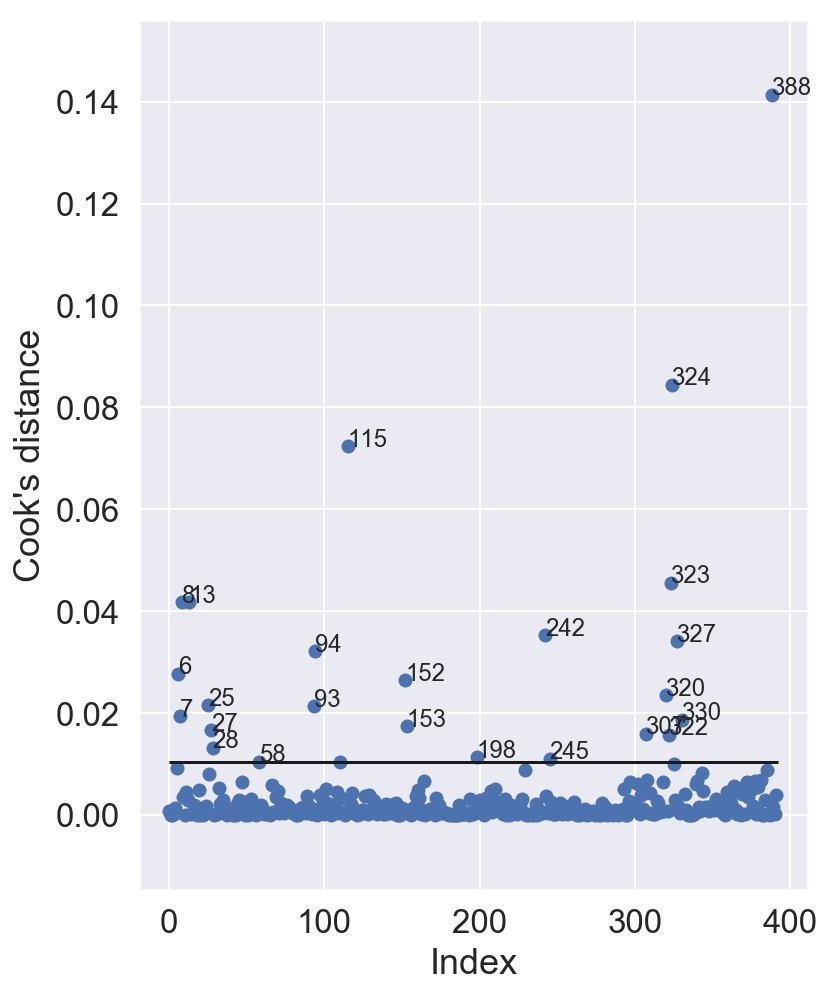

In [31]:
threshold = 3*cooks_distance.mean()
large_cook = np.argwhere(cooks_distance > threshold)
points_annot = np.concatenate([large_cook, cooks_distance[large_cook]], axis=1)

fig, ax = plt.subplots(figsize=(6, 8))
ax.scatter(range(len(cooks_distance)), cooks_distance)
ax.hlines(threshold, 0, len(cooks_distance))
for index, value in points_annot:
    ax.annotate(int(index), (index, value), fontsize=12)
ax.set_xlabel('Index')
ax.set_ylabel("Cook's distance")
plt.show()

## Model with removed influential points

In [32]:
# our previous parameters
results.params

const           52.559325
horsepower      -0.187966
acceleration    -0.609772
dtype: float64

What happens if we exclude the very extreme observation 388?

In [33]:
df.loc[388, ['horsepower', 'acceleration']]

horsepower        52
acceleration    24.6
Name: 388, dtype: object

In [34]:
(df.loc[388, ['horsepower', 'acceleration']]-df[['horsepower',
                                                 'acceleration']].mean())/df[['horsepower', 'acceleration']].std()

horsepower     -1.36315
acceleration    3.28348
dtype: object

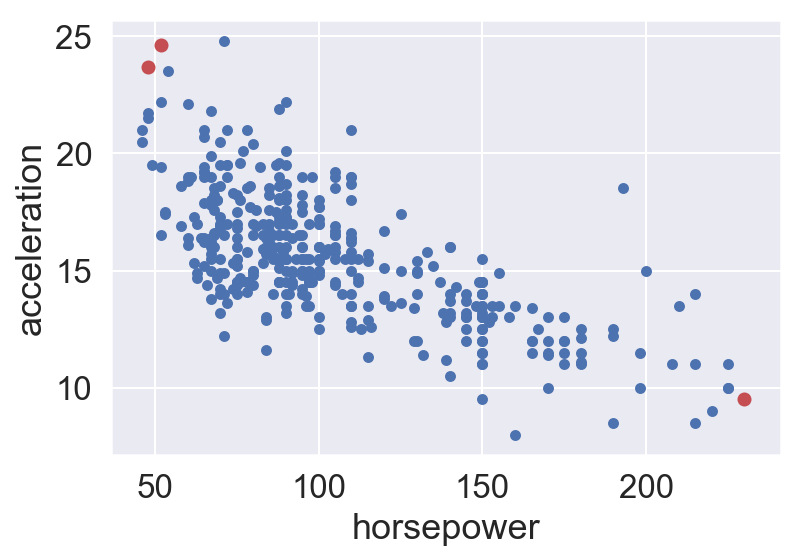

In [35]:
outliers = [388, 324, 115]
df.plot(x='horsepower', y='acceleration', kind='scatter', color='b')
plt.scatter(df.loc[outliers, 'horsepower'],
            df.loc[outliers, 'acceleration'], color='r')
plt.show()

In [36]:
df_no_outliers = df.copy()
df_no_outliers = df_no_outliers.drop(outliers)

In [37]:
results_no_outliers = sm.OLS(df_no_outliers.mpg, sm.add_constant(
    df_no_outliers[['horsepower', 'acceleration']])).fit()
results_no_outliers.params

const           54.984256
horsepower      -0.193797
acceleration    -0.733967
dtype: float64

In [38]:
# new rsquared
results_no_outliers.rsquared

0.6445543354677202

In [39]:
# old rsquared
results.rsquared

0.6303385179880157

## Variance inflation factor

The variance inflation factor measures how much any variable can already be determined based on the others. Any one of the variables is fitted versus all the others obtaining an R^2-score.
The variance inflation factor for variable $i$ is then given by

$$
{\rm VIF}_i = \frac{1}{1-R^2_i}
$$

Perfect multicollinearity leads to infinite VIF.

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [41]:
X = df[[col for col in df.columns if col not in ['mpg', 'origin', 'name', 'brand']]]

In [42]:
X.shape

(392, 7)

In [43]:
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif

[8.403005818649698,
 119.87286739228844,
 87.06496717910684,
 77.33010287827061,
 143.45527404034635,
 86.27640522084272,
 196.559156373442]

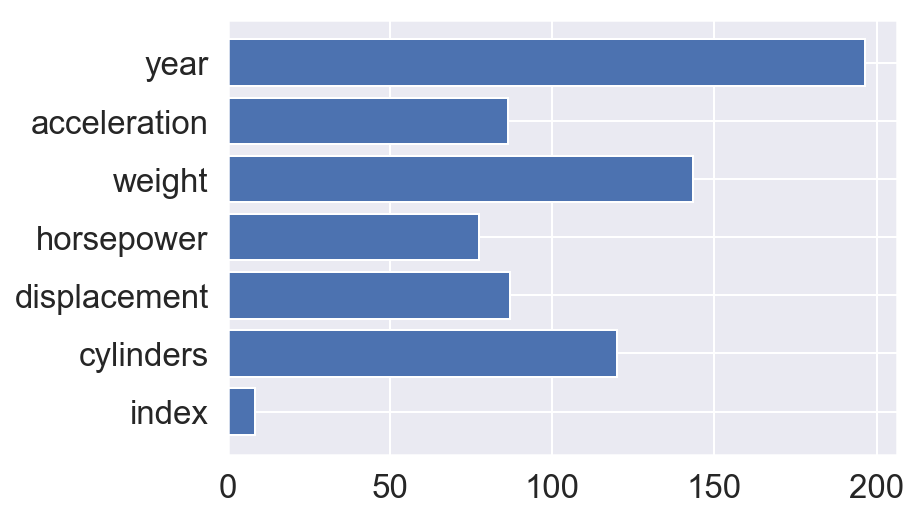

In [44]:
plt.barh(X.columns, vif)
plt.show()